In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import jieba.posseg as psg  #jieba词性的包
import jieba
import warnings
warnings.filterwarnings("ignore")

#将matplotlib的图表直接嵌入到Notebook之中
%matplotlib inline  

# path = '/home/kesci/input/emotion_analysi7147'

In [2]:
file_path = r"D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\数据\xiaomi.csv"
df = pd.read_csv(file_path)
df

,用户名,内容,点赞量,日期
0,SupremeWow,小米su7强势破圈太火爆了，雷总得抓紧提高产能啊,3025,2024-03-30 12:22:53
1,及米侠,感觉这次黑稿不太多，看来车圈还是更干净一些！,1725,2024-03-30 12:23:26
2,小麦Elite,小米手机1代回忆～,1020,2024-03-30 12:22:38
3,米12U,雷总辛苦了 感谢您为大家做了一辆Dream car,660,2024-03-30 12:22:39
4,Spider_boy666,雷总加电,650,2024-03-30 12:23:00
...,...,...,...,...
4568,春夏秋冬湖,欢迎雷军🍉,0,2024-05-18 19:58:08
4569,四季的暖窝,雷总，能不能发售ARE U OK大字母 运动包 能不能开MI家HOTEL，用SU7接送客人到MI家,0,2024-05-18 19:48:31
4570,米粉玩车局,中国平安的平安车险，未经本人允许，滥用本人姓名、电话、身份证信息，连续一个月车险客服电话骚扰...,0,2024-05-18 17:45:00
4571,浦东机场上空的轰鸣,不想体验你们的最新科技，雷嗨,0,2024-05-18 17:42:53


In [3]:
# 删除 '内容' 列中包含空值的所有行
df = df.dropna()

# 删除重复
df = df.drop_duplicates()
df.shape

(3591, 4)

In [4]:
# 删除数据记录中所有列值相同的记录
df['内容'] = df[['内容']].drop_duplicates()
df.shape

(3591, 4)

In [5]:


# 分词并赋词性
if not isinstance(df['内容'], pd.Series):
    content = pd.Series(df['内容'])
else:
    content = df['内容']
    
content = df['内容'].astype(str)

worker = lambda s: [(x.word, x.flag) for x in psg.cut(s)] # 自定义简单分词函数
content = content.astype(str)

seg_word = content.apply(worker)
seg_word = pd.Series(seg_word)
seg_word.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Peng Yitong\AppData\Local\Temp\jieba.cache
Loading model cost 0.616 seconds.
Prefix dict has been built successfully.


0    [(小米, n), (su7, eng), (强势, n), (破圈, n), (太, d)...
1    [(感觉, n), (这次, r), (黑稿, n), (不, d), (太, d), (多...
2    [(小米, n), (手机, n), (1, m), (代, n), (回忆, v), (～...
3    [(雷总, nr), (辛苦, a), (了, ul), ( , x), (感谢您, l),...
4                                  [(雷总, nr), (加电, v)]
Name: 内容, dtype: object

In [6]:
### 将词语转为数据框形式，一列是词，一列是词语所在的句子ID
n_word = seg_word.apply(lambda x: len(x))  # 每一评论中词的个数

n_content = [[x+1]*y for x,y in zip(list(seg_word.index), list(n_word))]

# 将嵌套的列表展开，作为词所在评论的id
index_content = sum(n_content, [])  
#sum() 可以用于列表的展开，效果相当于各子列表相加

seg_word = sum(seg_word, [])
# 词
word = [x[0] for x in seg_word]
# 词性
nature = [x[1] for x in seg_word]

result = pd.DataFrame({"index_content":index_content, 
                       "word":word,
                       "nature":nature})

result.head(20)

,index_content,word,nature
0,1,小米,n
1,1,su7,eng
2,1,强势,n
3,1,破圈,n
4,1,太,d
5,1,火爆,a
6,1,了,ul
7,1,，,x
8,1,雷,n
9,1,总得,v


In [7]:
# 删除标点符号
result = result[result['nature'] != 'x']  # x表示标点符号

# 删除停用词
stop_path = open("D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\数据\stopwords_cn.txt", 'r',encoding='UTF-8')
stop = stop_path.readlines()
stop = [x.replace('\n', '') for x in stop]
word = list(set(word) - set(stop))
result = result[result['word'].isin(word)]

# 删除 word 列为空值的行
result = result.dropna(subset=['word'])

# 重置索引，避免因行删除导致的索引不连续问题
result = result.reset_index(drop=True)

result = result[result['word'] != 'nan']

result.head(15)

,index_content,word,nature
0,1,小米,n
1,1,su7,eng
2,1,强势,n
3,1,破圈,n
4,1,火爆,a
5,1,雷,n
6,1,总得,v
7,1,抓紧,v
8,1,提高,v
9,1,产能,v


In [8]:
# 构造各词在对应评论的位置列
n_word = list(result.groupby(by = ['index_content'])['index_content'].count())
index_word = [list(np.arange(0, y)) for y in n_word]
# 词语在该评论的位置
index_word = sum(index_word, [])
# 合并评论id
result['index_word'] = index_word
result.head(15)

,index_content,word,nature,index_word
0,1,小米,n,0
1,1,su7,eng,1
2,1,强势,n,2
3,1,破圈,n,3
4,1,火爆,a,4
5,1,雷,n,5
6,1,总得,v,6
7,1,抓紧,v,7
8,1,提高,v,8
9,1,产能,v,9


In [9]:
countwords1 = result['word']
countwords1.shape

(31121,)

In [10]:
# 删除数据记录中所有列值相同的记录
countwords2 = result['word'].drop_duplicates()
countwords2.shape

(7248,)

In [11]:
# # 提取含有名词类的评论,即词性含有“n”的评论
# ind = result[['n' in x for x in result['nature']]]['index_content'].unique()
# result = result[[x in ind for x in result['index_content']]]
# result

In [12]:
# 读入正面、负面情感评价词
pos_comment = pd.read_csv("D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\数据\正面评价词语（中文）.txt", header=None,sep="\t", 
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv("D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\数据\负面评价词语（中文）.txt", header=None,sep="\t", 
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv("D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\数据\正面情感词语（中文）.txt", header=None,sep="\t", 
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv("D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\数据\负面情感词语（中文）.txt", header=None,sep="\t", 
                          encoding = 'utf-8', engine='python') 

# 合并情感词与评价词
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])

# 正负面情感词表中相同的词语
intersection = positive&negative

positive = list(positive - intersection)
negative = list(negative - intersection)

positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)}) 

posneg = positive._append(negative)

posneg['word'] = posneg['word'].str.strip()

# 将分词结果与正负面情感词表合并，定位情感词
data_posneg = posneg.merge(result,on = 'word', how = 'right')
data_posneg = data_posneg.sort_values(by = ['index_content'])

data_posneg.head(10)


,word,weight,index_content,nature,index_word
0,小米,NaN,1,n,0
1,su7,NaN,1,eng,1
2,强势,1.0,1,n,2
3,破圈,NaN,1,n,3
4,火爆,NaN,1,a,4
5,雷,NaN,1,n,5
6,总得,NaN,1,v,6
7,抓紧,1.0,1,v,7
8,提高,NaN,1,v,8
9,产能,NaN,1,v,9


In [13]:
positive_comments = data_posneg[data_posneg['weight'] == 1]
positive_comments.shape

(3088, 5)

In [14]:
negative_comments = data_posneg[data_posneg['weight'] == -1]
negative_comments.shape

(738, 5)

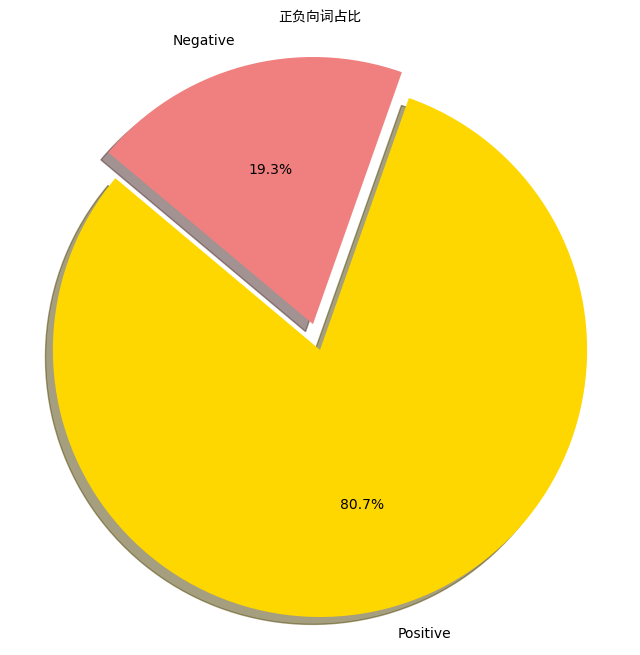

In [15]:
from matplotlib.font_manager import FontProperties

# 统计正面和负面情感词的数量
positive_count = data_posneg[data_posneg['weight'] == 1].shape[0]
negative_count = data_posneg[data_posneg['weight'] == -1].shape[0]

# 设置字体属性
font_path = "C:\\Windows\\Fonts\\SimHei.ttf"  # Windows路径
font_prop = FontProperties(fname=font_path)


# 绘制饼图
labels = 'Positive', 'Negative'
sizes = [positive_count, negative_count]
colors = ['gold', 'lightcoral']
explode = (0.1, 0)  # 突出显示正面的部分

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('正负向词占比', fontproperties=font_prop)

# 保存图表
output_path = r'D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\可视化\正负向占比.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

修正情感倾向

In [16]:
# 载入否定词表
notdict = pd.read_csv("not.csv")

# 构造新列，作为经过否定词修正后的情感值
data_posneg['amend_weight'] = data_posneg['weight']
data_posneg['id'] = np.arange(0, len(data_posneg))

# 只保留有情感值的词语
only_inclination = data_posneg.dropna().reset_index(drop=True)

index = only_inclination['id']


for i in np.arange(0, len(only_inclination)):
    # 提取第i个情感词所在的评论
    review = data_posneg[data_posneg['index_content'] == only_inclination['index_content'][i]]
    review.index = np.arange(0, len(review))
    # 第i个情感值在该文档的位置
    affective = only_inclination['index_word'][i]
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])%2
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]          
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1, 
                  affective - 2]]])%2
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]
            

            
# 更新只保留情感值的数据
only_inclination = only_inclination.dropna()

# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],
                                           as_index=False)['amend_weight'].sum()

# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]

In [17]:
# 给情感值大于0的赋予评论类型（content_type）为pos,小于0的为neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'

emotional_value

,index_content,amend_weight,a_type
0,1,2.0,pos
1,2,1.0,pos
2,4,1.0,pos
3,6,1.0,pos
4,8,2.0,pos
...,...,...,...
1786,4153,1.0,pos
1787,4159,2.0,pos
1788,4160,1.0,pos
1789,4161,3.0,pos


In [18]:
# 查看情感分析结果
result = emotional_value.merge(data_posneg, 
                               left_on = 'index_content', 
                               right_on = 'index_content',
                               how = 'left')

# 重命名列以避免冲突
result.rename(columns={'amend_weight_x': 'amend_weight_sum', 'amend_weight_y': 'amend_weight'}, inplace=True)

# 去除重复的列
result.drop(columns=['weight'], inplace=True)

result.head()


,index_content,amend_weight_sum,a_type,word,nature,index_word,amend_weight,id
0,1,2.0,pos,小米,n,0,NaN,0
1,1,2.0,pos,su7,eng,1,NaN,1
2,1,2.0,pos,强势,n,2,1.0,2
3,1,2.0,pos,破圈,n,3,NaN,3
4,1,2.0,pos,火爆,a,4,NaN,4


amend_weight：
这是从 data_posneg DataFrame 中来的列。
它表示每个词的修正后的情感权重。
例如，如果评论中的一个词是正面词并且没有被否定词修正，它的 amend_weight 可能是 1；如果它是负面词并且被否定词修正，它的 amend_weight 可能是 -1。

amend_weight_sum：
这是从 emotional_value DataFrame 中来的列。
它表示每条评论的情感值总和，即在每条评论中所有情感词的修正后的情感权重的总和。
例如，如果一条评论包含多个情感词，每个词都有一个修正后的情感权重，那么 amend_weight_sum 就是这些权重的和。

In [19]:
# 选出 amend_weight 列中值为 -1 的行
negative_weights = result[result['amend_weight'] == -1]

# 查看选出的结果
negative_weights.shape

(588, 8)

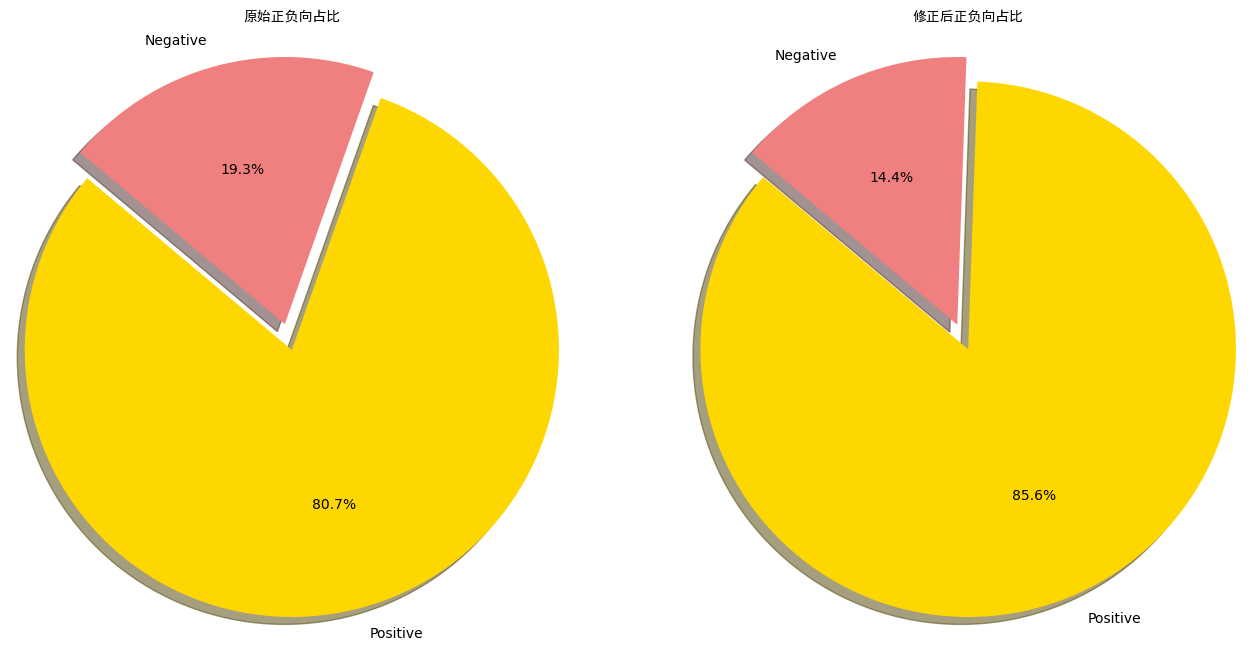

In [20]:
import matplotlib.pyplot as plt

# 统计原始正面和负面情感词的数量
positive_count1 = data_posneg[data_posneg['weight'] == 1].shape[0]
negative_count1 = data_posneg[data_posneg['weight'] == -1].shape[0]

# 统计修正后正面和负面情感词的数量
positive_count2 = result[result['a_type'] == 'pos'].shape[0]
negative_count2 = result[result['a_type'] == 'neg'].shape[0]

# 创建并排显示的两个子图
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# 绘制第一个饼图
labels1 = ['Positive', 'Negative']
sizes1 = [positive_count1, negative_count1]
colors1 = ['gold', 'lightcoral']
explode1 = (0.1, 0)  # 突出显示正面的部分

axs[0].pie(sizes1, explode=explode1, labels=labels1, colors=colors1,
           autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title('原始正负向占比', fontproperties=font_prop)

# 绘制第二个饼图
labels2 = ['Positive', 'Negative']
sizes2 = [positive_count2, negative_count2]
colors2 = ['gold', 'lightcoral']
explode2 = (0.1, 0)  # 突出显示正面的部分

axs[1].pie(sizes2, explode=explode2, labels=labels2, colors=colors2,
           autopct='%1.1f%%', shadow=True, startangle=140)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title('修正后正负向占比', fontproperties=font_prop)

# 保存图表
output_path = r'D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\可视化\正负向占比修正前后对比.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

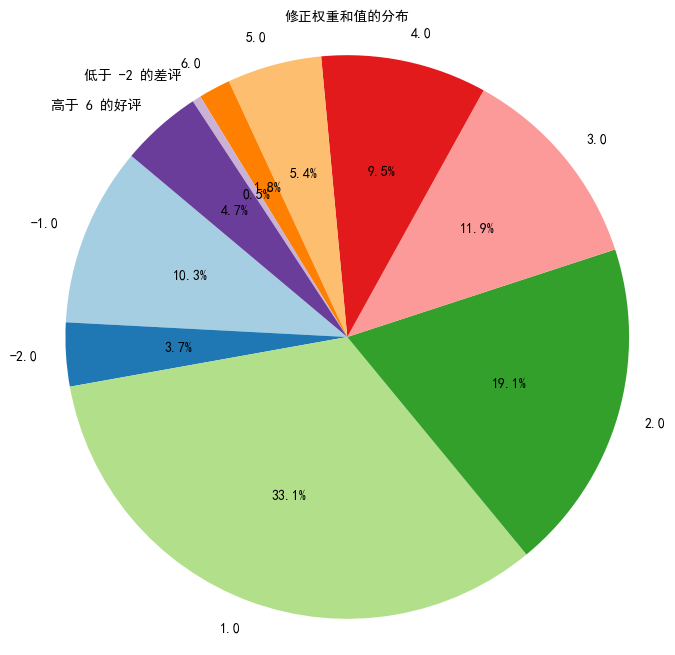

In [21]:

font_path = "C:\Windows\Fonts\SimHei.ttf"  # Windows路径
font_prop = FontProperties(fname=font_path)


# 对 amend_weight_sum 列进行分组
def categorize_amend_weight_sum(value):
    if value < -2:
        return "低于 -2 的差评"
    elif value > 6:
        return "高于 6 的好评"
    else:
        return str(value)

result['amend_weight_sum_category'] = result['amend_weight_sum'].apply(categorize_amend_weight_sum)

# 统计各分类的数量
amend_weight_sum_counts = result['amend_weight_sum_category'].value_counts()

# 按标签排序
amend_weight_sum_counts = amend_weight_sum_counts.sort_index()

# 绘制饼图
labels = amend_weight_sum_counts.index.tolist()
sizes = amend_weight_sum_counts.values.tolist()
colors = plt.cm.Paired(range(len(labels)))  # 使用 colormap

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140, textprops={'fontproperties': font_prop})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('修正权重和值的分布', fontproperties=font_prop)

# 保存图表
output_path = r'D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\可视化\修正后各得分占比.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

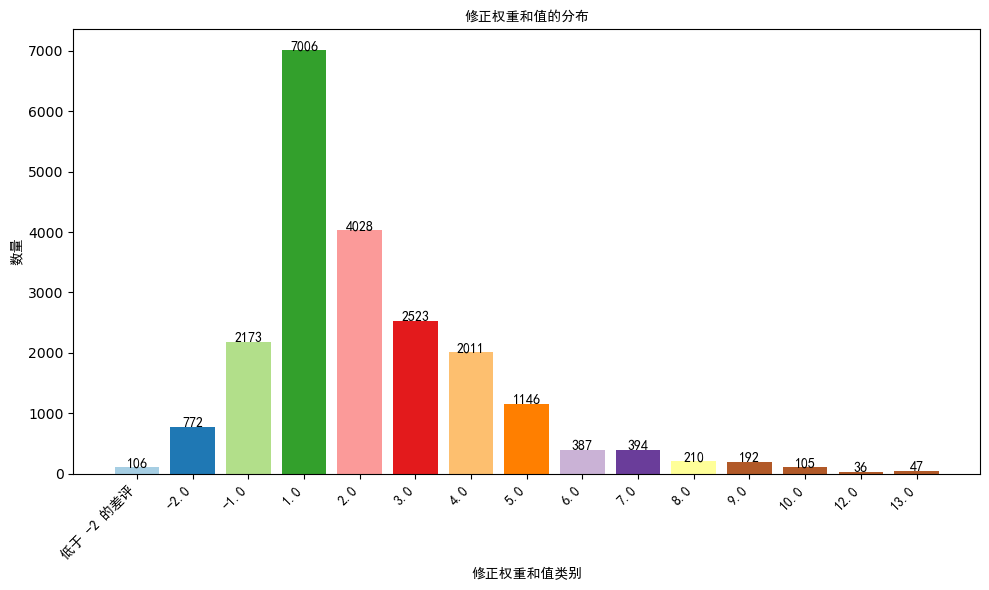

In [22]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

# 设置字体属性
font_path = "C:\\Windows\\Fonts\\SimHei.ttf"  # Windows路径
font_prop = FontProperties(fname=font_path)

# 对 amend_weight_sum 列进行分组
def categorize_amend_weight_sum(value):
    if value < -2:
        return "低于 -2 的差评"
    else:
        return str(value)

result['amend_weight_sum_category'] = result['amend_weight_sum'].apply(categorize_amend_weight_sum)

# 统计各分类的数量
amend_weight_sum_counts = result['amend_weight_sum_category'].value_counts()

# 将分类标签按指定顺序排序
sorted_labels = ['低于 -2 的差评'] + sorted([label for label in amend_weight_sum_counts.index if label != '低于 -2 的差评'], key=lambda x: float(x))
amend_weight_sum_counts = amend_weight_sum_counts.reindex(sorted_labels)

# 绘制柱状图
labels = amend_weight_sum_counts.index.tolist()
sizes = amend_weight_sum_counts.values.tolist()
colors = plt.cm.Paired(range(len(labels)))  # 使用 colormap

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, sizes, color=colors)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 1), ha='center', fontproperties=font_prop)

plt.xlabel('修正权重和值类别', fontproperties=font_prop)
plt.ylabel('数量', fontproperties=font_prop)
plt.title('修正权重和值的分布', fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)  # 标签旋转并右对齐

# 保存图表
output_path = r'D:\MINE\大数据分析综合实验\大数据2102班_彭弋桐_基于小米su7评论的情感分析和数据分析\可视化\修正后各得分分布.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')


plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

In [23]:
# 提取index_content和amend_weight_sum列并去除重复
emotional_summary = result[['index_content', 'amend_weight_sum']].drop_duplicates()
# emotional_summary

# 将index_content减1以与df的索引对齐
emotional_summary['index_content'] -= 1

# 重命名列以便合并
emotional_summary.rename(columns={'index_content': 'index'}, inplace=True)

# 设置index列为索引
emotional_summary.set_index('index', inplace=True)

# 与原始DataFrame合并
emotion_assess = df.merge(emotional_summary, left_index=True, right_index=True, how='left')
# emotion_assess

# 删除含有空值的行
emotion_assess = emotion_assess.dropna(subset=['内容'])

# 算长度
emotion_assess['length'] = emotion_assess['内容'].apply(lambda x: len(x))

# 保存结果
emotion_assess.to_csv("情感赋值.csv", index=False, encoding='utf-8-sig')


神经网络&贝叶斯

In [24]:
import pandas as pd
import numpy as np
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [25]:
result

,index_content,amend_weight_sum,a_type,word,nature,index_word,amend_weight,id,amend_weight_sum_category
0,1,2.0,pos,小米,n,0,NaN,0,2.0
1,1,2.0,pos,su7,eng,1,NaN,1,2.0
2,1,2.0,pos,强势,n,2,1.0,2,2.0
3,1,2.0,pos,破圈,n,3,NaN,3,2.0
4,1,2.0,pos,火爆,a,4,NaN,4,2.0
...,...,...,...,...,...,...,...,...,...
21131,4161,3.0,pos,喜欢,v,0,1.0,31403,3.0
21132,4161,3.0,pos,穿着,v,3,NaN,31404,3.0
21133,4181,1.0,pos,米,q,1,NaN,31415,1.0
21134,4181,1.0,pos,汽车,n,2,NaN,31416,1.0


In [26]:
X = result['word'].astype(str).fillna('')
y = result['a_type']

In [27]:

import pandas as pd
# pd.set_option('display.max_columns', None)  # 添加这行代码可以显示所有列，如果讲None改成500，则表示可最多显示500列
# pd.set_option('display.max_rows', None)  # 添加这行代码可以显示所有行，如果讲None改成500，则表示可最多显示500行
pd.DataFrame(X).head()

,word
0,小米
1,su7
2,强势
3,破圈
4,火爆


In [28]:
y = result['a_type']
y.head()

0    pos
1    pos
2    pos
3    pos
4    pos
Name: a_type, dtype: object

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 创建一个 TfidfVectorizer 对象
vectorizer = TfidfVectorizer()

# 将文本数据转换为 TF-IDF 特征矩阵
X_tfidf = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=1)

from sklearn.neural_network import MLPClassifier
mlp =MLPClassifier()  
mlp.fit(X_train, y_train)

MLPClassifier()

In [48]:
y_pred = mlp.predict(X_test)
y_pred

array(['pos', 'pos', 'pos', ..., 'pos', 'pos', 'pos'], dtype='<U3')

In [31]:
a = pd.DataFrame()  # 创建一个空DataFrame 
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,pos,pos
1,pos,pos
2,pos,pos
3,pos,pos
4,pos,neg


In [49]:
# 获取预测准确度
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.8675496688741722

In [50]:
# 通过模型自带的score()函数也可以获取预测准确度
mlp.score(X_test, y_test)

0.8675496688741722

In [100]:
# 自我体验1
comment = input('请输入您对小米su7的评价：')
comment = [' '.join(jieba.cut(comment))]
print(comment)
X_try = vectorizer.transform(comment)
y_pred = mlp.predict(X_try.toarray())
print(y_pred)

请输入您对小米su7的评价：雷总很厉害
['雷总 很 厉害']
['pos']


In [55]:
# 自我体验2
comment = input('请输入您对小米su7的评价：')
comment = [' '.join(jieba.cut(comment))]
print(comment)
X_try = vectorizer.transform(comment)
y_pred = mlp.predict(X_try.toarray())
print(y_pred)

请输入您对小米su7的评价：期待开su7上路
['期待 开 su7 上路']
['pos']


In [98]:
# 自我体验3
comment = input('请输入您对小米su7的评价：')
comment = [' '.join(jieba.cut(comment))]
print(comment)
X_try = vectorizer.transform(comment)
y_pred = mlp.predict(X_try.toarray())
print(y_pred)

请输入您对小米su7的评价：新能源车中遥遥领先
['新能源 车中 遥遥领先']
['pos']


In [39]:
# 自我体验4
comment = input('请输入您对小米su7的评价：')
comment = [' '.join(jieba.cut(comment))]
print(comment)
X_try = vectorizer.transform(comment)
y_pred = mlp.predict(X_try.toarray())
print(y_pred)

请输入您对小米su7的评价：su7不是抄袭的保时捷的设计吗
['su7 不是 抄袭 的 保时捷 的 设计 吗']
['pos']


In [45]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [53]:
# 自我体验5
comment = input('请输入您对小米su7的评价：')
comment = [' '.join(jieba.cut(comment))]
print(comment)
X_try = vectorizer.transform(comment)
y_pred = mlp.predict(X_try.toarray())
print(y_pred)

请输入您对小米su7的评价：su7不是抄袭的保时捷的设计吗
['su7 不是 抄袭 的 保时捷 的 设计 吗']
['pos']


In [ ]:
# 欠采样处理数据不平衡问题
under_sampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# 数据标准化
scaler = StandardScaler(with_mean=False)
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 训练模型
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200)
mlp.fit(X_train_resampled_scaled, y_train_resampled)

# 评估模型
y_pred_test = mlp.predict(X_test_scaled)

In [41]:
# 朴素贝叶斯模型对比
from sklearn.naive_bayes import GaussianNB

# 创建一个 TfidfVectorizer 对象
vectorizer = TfidfVectorizer()

# 将文本数据转换为 TF-IDF 特征矩阵
X_tfidf = vectorizer.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=1)

# 初始化朴素贝叶斯分类器
nb_clf = GaussianNB()

# 将训练集转换为稠密数组
X_train_dense = X_train.toarray()

# 训练朴素贝叶斯分类器
nb_clf.fit(X_train_dense, y_train)

# 将测试集转换为稠密数组
X_test_dense = X_test.toarray()

# 使用训练好的分类器进行预测
y_pred = nb_clf.predict(X_test_dense)
y_pred

array(['neg', 'pos', 'pos', ..., 'neg', 'neg', 'pos'], dtype='<U3')

In [44]:
from sklearn.metrics import accuracy_score
score3 = accuracy_score(y_pred, y_test)
score

0.35714285714285715